### Introduction
Restaurant business is considered to be stable if the demographics requirements are met. Especially, crowded metropolis areas require restaurants for busy people who work in the city and prefer dining-out than cooking at home. For our studies we are interested in Japanese cuisine as it is the favorite of big audiences.
Location-wise Toronto is the most-populated city in Canada with over 6 million people in 2020 with the highest median salary of 123,000 CAD across the country. Thus it is believed that restaurant business goes well around the city. This study is going to analyze the best possible location for our Japanese Restaurant in Toronto, Canada so potential stakeholders could achieve great success and consistent profit.

### Business Problem
The objective of this project is to analyze and select the best locations in the city of Toronto, Canada to open a new Japanese restaurant. Utilizing data science methodology and instruments such as data analysis and data visualization project aims to provide solutions for our business problem: Where in Toronto, Canada should the investor open a Japanese Restaurant.

### Data Description
The following data will be used:
    • Toronto, Canada data containing neighborhoods and boroughs
    • Latitude and Longitude coordinates of these neighborhoods for plotting the map
    • Venue data, namely restaurants data of Toronto

### Data Source
Toronto data source for neighborhoods and boroughs will be obtained from Wikipedia and wrangled with python pandas library. Geographical coordinates (latitude, longitude) will be retrieved from the website provided by IBM: http://cocl.us/Geospatial_data
To obtain venue data for the neighborhoods I will use Foursquare API. Foursquare is one of the largest database for location data with over 100 million places. Foursquare API provides different categories of the venue data, particularly restaurant data that allows to find the solution to the business problem.

### 1. Libraries are downloaded to proceed to work with data

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip3 install lxml

In [1]:


import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


### 1.1 Foursquare Credentials

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'V4ACAI1FJ2NIBRDZGX20WBSKYUQOIQWTZPPEVXOM1RGDEUFK' # your Foursquare ID
CLIENT_SECRET = 'ID12EH4WS30IWKRZV4M3DHOPJDEZTPDEPDG1S4VHVRP44YZ2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


### 1.2 Download Data for Toronto, Canada

In [3]:
# First, we download html of Toronto boroughs into our notebook

pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# Secondly, we define our dataframe and assign it to pandas dataframe to have a clean look

toronto_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Thirdly, we drop Boroughs with Not assigned values
# And assign Borough names to Neighbourhoods with 'Not assigned' values

t_df = toronto_df[toronto_df.Borough != 'Not assigned'].reset_index().drop('index', axis=1)
for index, row in t_df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']
        
# Here, we download csv of postal codes lattitude and longitude

latlong_df = pd.read_csv('http://cocl.us/Geospatial_data')

# Joining 2 Dataframes, namely Boroughs, Neighbourhoods with Lattitude, Longitude into 1

tor_df = t_df.set_index('Postal Code').sort_values(by='Postal Code')
ll_df = latlong_df.set_index('Postal Code').sort_values(by='Postal Code')
df_join = pd.concat([tor_df, ll_df], axis=1)
toronto_df = df_join.reset_index()
toronto_data = toronto_df.drop(['Postal Code'], axis=1)
toronto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


### 1.3 Define Functions for further use in our Project

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### 2. Data Analysis to find out number of Japanese Restaurants in Toronto

In [5]:
# Prepare neighborhood list that contains japanese restaurants

column_names=['Borough', 'Neighbourhood', 'ID','Name']
japanese_rest_t=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(toronto_data),')','Japanese Restaurants in '+Neighbourhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_t = japanese_rest_t.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Japanese Restaurants in Malvern, Rouge, Scarborough:0
['Scarborough', 'Malvern, Rouge', 43.806686299999996, -79.19435340000001]
( 2 / 103 ) Japanese Restaurants in Rouge Hill, Port Union, Highland Creek, Scarborough:0
['Scarborough', 'Rouge Hill, Port Union, Highland Creek', 43.7845351, -79.16049709999999]
( 3 / 103 ) Japanese Restaurants in Guildwood, Morningside, West Hill, Scarborough:0
['Scarborough', 'Guildwood, Morningside, West Hill', 43.7635726, -79.1887115]
( 4 / 103 ) Japanese Restaurants in Woburn, Scarborough:0
['Scarborough', 'Woburn', 43.7709921, -79.21691740000001]
( 5 / 103 ) Japanese Restaurants in Cedarbrae, Scarborough:0
['Scarborough', 'Cedarbrae', 43.773136, -79.23947609999999]
( 6 / 103 ) Japanese Restaurants in Scarborough Village, Scarborough:0
['Scarborough', 'Scarborough Village', 43.7447342, -79.23947609999999]
( 7 / 103 ) Japanese Restaurants in Kennedy Park, Ionview, East Birchmount Park, Scarborough:0
['Scarborough', 'Kennedy Park, Ionview, Eas

KeyError: 'groups'

In [6]:
#japanese_rest_t.to_csv('japanese_rest_t_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_t.to_csv('japanese_rest_t_tocsv1.csv')

In [7]:
japanese_t = pd.read_csv('japanese_rest_t_tocsv1.csv')
japanese_rest_t.tail()

,Borough,Neighbourhood,ID,Name
28,Downtown Toronto,"First Canadian Place, Underground city",5a4fdf56772fbc5e9fa73c7f,Chotto Matte
29,Downtown Toronto,"First Canadian Place, Underground city",506a3830e4b0677a1f9d8eda,Ninki Izakaya
30,Downtown Toronto,"First Canadian Place, Underground city",4afa1f33f964a520e91622e3,Fune Japanese Restaurant
31,North York,Glencairn,4fca732be4b07c8e3e198c27,Miyako Sushi Restaurant
32,West Toronto,"Little Portugal, Trinity",51049684e4b06b57cac4e3e8,Bazara


In [8]:
japanese_rest_t.shape

(33, 4)

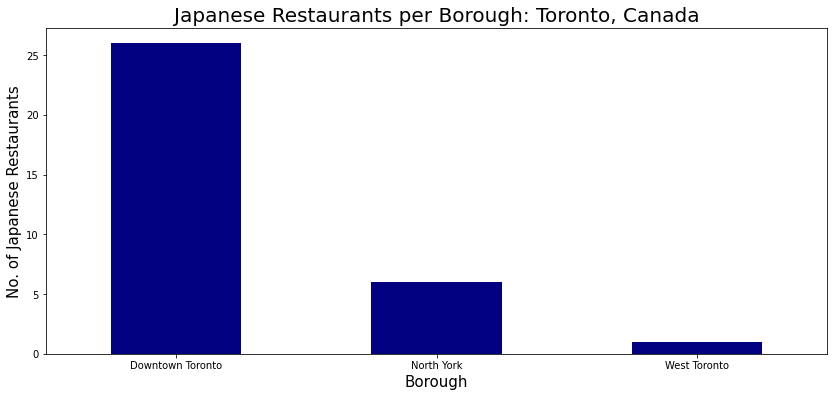

In [9]:
japanese_rest_t.groupby('Borough')['ID'].count().plot.bar(figsize=(14,6), color='navy')
plt.title('Japanese Restaurants per Borough: Toronto, Canada', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

As we can see from empirical results above, Toronto has the total of 33 Japanese Restaurants, majority of them, specifically 26 located in Downtown Toronto area.

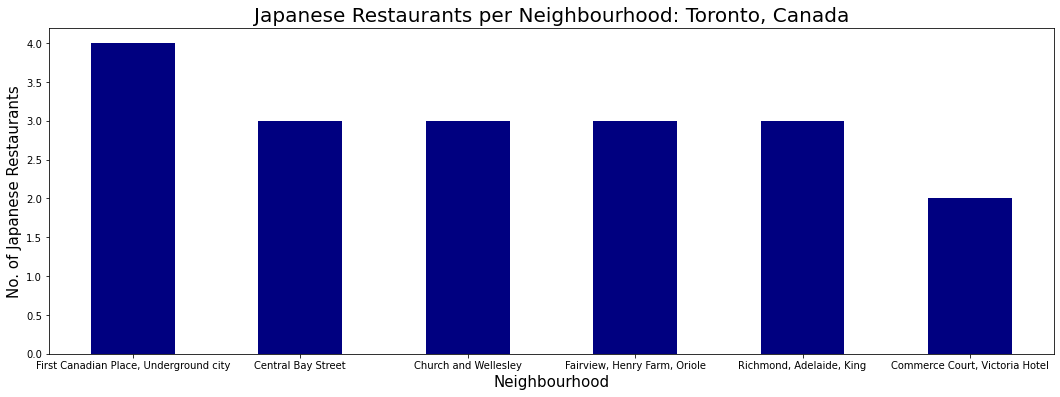

In [10]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_t.groupby('Neighbourhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(18,6), color='navy')
plt.title('Japanese Restaurants per Neighbourhood: Toronto, Canada', fontsize = 20)
plt.xlabel('Neighbourhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

###  2.1 Rankings of the Found Restaurants

In [11]:
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_t=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_t.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_t),')','processed')
    japanese_rest_stats_t = japanese_rest_stats_t.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_t.tail()

{'meta': {'code': 200, 'requestId': '5faed570164c641f7b116e16'}, 'response': {'venue': {'id': '5952e5ed491be7022cf5d19f', 'name': 'Heart Sushi', 'contact': {}, 'location': {'address': '1800 Sheppard Avenue E', 'lat': 43.777203, 'lng': -79.343805, 'labeledLatLngs': [{'label': 'display', 'lat': 43.777203, 'lng': -79.343805}], 'postalCode': 'M2J', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1800 Sheppard Avenue E', 'Toronto ON M2J', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/heart-sushi/5952e5ed491be7022cf5d19f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi Restaurants', 'shortName': 'Sushi', 'icon': {'prefix': 'https://ss3.4sqi.net/img/catego

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
28,Downtown Toronto,"First Canadian Place, Underground city",5a4fdf56772fbc5e9fa73c7f,Chotto Matte,12,8.0,2
29,Downtown Toronto,"First Canadian Place, Underground city",506a3830e4b0677a1f9d8eda,Ninki Izakaya,9,7.6,5
30,Downtown Toronto,"First Canadian Place, Underground city",4afa1f33f964a520e91622e3,Fune Japanese Restaurant,53,7.6,27
31,North York,Glencairn,4fca732be4b07c8e3e198c27,Miyako Sushi Restaurant,8,6.8,3
32,West Toronto,"Little Portugal, Trinity",51049684e4b06b57cac4e3e8,Bazara,28,8.1,15


In [12]:
japanese_rest_stats_t.shape

(33, 7)

### 2.2 Preparation for further analysis

In [13]:
# Now, we check the information about our dataframe

japanese_rest_stats_t.dtypes

Borough           object
Neighbourhood     object
ID                object
Name              object
Likes             object
Rating           float64
Tips              object
dtype: object

In [14]:
# We change our values from object to float

japanese_rest_stats_t['Likes'] = japanese_rest_stats_t['Likes'].astype('float64')
japanese_rest_stats_t['Tips'] = japanese_rest_stats_t['Tips'].astype('float64')
japanese_rest_stats_t.dtypes

Borough           object
Neighbourhood     object
ID                object
Name              object
Likes            float64
Rating           float64
Tips             float64
dtype: object

We got all the Statistics for our 33 Japanese Restaurants

In [15]:
# Restaurant with maximum Likes

japanese_rest_stats_t.iloc[japanese_rest_stats_t['Likes'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood    Garden District, Ryerson
ID               4b2bd898f964a52042bc24e3
Name               Kinka Izakaya Original
Likes                                 385
Rating                                8.5
Tips                                  220
Name: 9, dtype: object

In [16]:
# Restaurant with maximum Ratings

japanese_rest_stats_t.iloc[japanese_rest_stats_t['Rating'].idxmax()]

Borough                                           Downtown Toronto
Neighbourhood    Harbourfront East, Union Station, Toronto Islands
ID                                        56201ed4498e7f700c462170
Name                                                          Miku
Likes                                                          142
Rating                                                           9
Tips                                                            47
Name: 19, dtype: object

In [17]:
# Restaurant with maximum Tips

japanese_rest_stats_t.iloc[japanese_rest_stats_t['Tips'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood    Garden District, Ryerson
ID               4b2bd898f964a52042bc24e3
Name               Kinka Izakaya Original
Likes                                 385
Rating                                8.5
Tips                                  220
Name: 9, dtype: object

In [18]:
# We check the statistical values of our variables to make sure they are ready for our analysis

japanese_rest_stats_t.describe()

,Likes,Rating,Tips
count,33.000000,33.000000,33.000000
mean,48.393939,7.242424,26.000000
std,70.844433,1.984948,40.690908
min,0.000000,0.000000,0.000000
25%,12.000000,7.300000,3.000000
50%,27.000000,7.700000,12.000000
75%,53.000000,8.000000,33.000000
max,385.000000,9.000000,220.000000


### 3. Visualization of neighbourhood with maximum average restaurant rating

In [19]:
t_neighborhood_stats=japanese_rest_stats_t.groupby('Neighbourhood', as_index=False).mean()[['Neighbourhood','Rating']]
t_neighborhood_stats.columns=['Neighbourhood','Average Rating']
t_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
8,"Harbourfront East, Union Station, Toronto Islands",9.000
15,"University of Toronto, Harbord",8.800
12,"St. James Town, Cabbagetown",8.700
11,St. James Town,8.350
9,"Little Portugal, Trinity",8.100
2,"Commerce Court, Victoria Hotel",7.950
14,"Toronto Dominion Centre, Design Exchange",7.950
6,"Garden District, Ryerson",7.950
13,Stn A PO Boxes,7.950
5,"First Canadian Place, Underground city",7.775


These above are the average rating of restaurants by neighborhood

In [20]:
t_borough_stats=japanese_rest_stats_t.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
t_borough_stats.columns=['Borough','Average Rating']
t_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,West Toronto,8.100000
0,Downtown Toronto,7.838462
1,North York,4.516667


Similarly, above average rating by boroughs

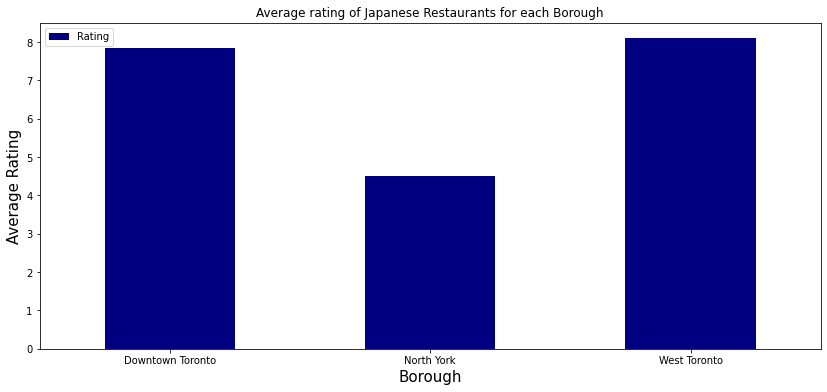

In [21]:
# Let's plot our results for ratings above
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_t.groupby('Borough').mean()['Rating'].plot(kind='bar', figsize=(14,6), color='navy')
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [22]:
# We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on a map
t_neighborhood_stats=t_neighborhood_stats[t_neighborhood_stats['Average Rating']>=7.0]
t_neighborhood_stats

,Neighbourhood,Average Rating
0,Central Bay Street,7.333333
1,Church and Wellesley,7.266667
2,"Commerce Court, Victoria Hotel",7.950000
5,"First Canadian Place, Underground city",7.775000
6,"Garden District, Ryerson",7.950000
8,"Harbourfront East, Union Station, Toronto Islands",9.000000
9,"Little Portugal, Trinity",8.100000
10,"Richmond, Adelaide, King",7.366667
11,St. James Town,8.350000
12,"St. James Town, Cabbagetown",8.700000


In [23]:
# We will join this Dataset to original Toronto data to get longitude and latitude
t_neighborhood_stats=pd.merge(t_neighborhood_stats,toronto_data, on='Neighbourhood')
t_neighborhood_stats=t_neighborhood_stats[['Borough','Neighbourhood','Latitude','Longitude','Average Rating']]
t_neighborhood_stats

,Borough,Neighbourhood,Latitude,Longitude,Average Rating
0,Downtown Toronto,Central Bay Street,43.657952,-79.387383,7.333333
1,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,7.266667
2,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,7.950000
3,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,7.775000
4,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,7.950000
5,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,9.000000
6,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,8.100000
7,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,7.366667
8,Downtown Toronto,St. James Town,43.651494,-79.375418,8.350000
9,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.700000


Now we will show above data applied to the map

### 4. Final Step: Visualization

In [24]:
# Create map and display it

t_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

# instantiate a feature group for the ratings in the dataframe

rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group

for lat, lng, in t_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [25]:
t_neighborhood_stats['Label']=t_neighborhood_stats['Neighbourhood']+', '+t_neighborhood_stats['Borough']+'('+t_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map

for lat, lng, label in t_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(t_map)
    
# add ratings to map

t_map.add_child(rating)

### Conclusion

In conclusion, in the city of Toronto there are only 33 Japanese Restaurants. For better results we have limited our research to higher rated Japanese Restaurants, specifically, starting from 7.0 on a 1.0 to 10.0 scale. Overall, majority of Restaurants located in Downtown Toronto, few are in West Toronto and lowest rated ones in North York. For ease of market entrance I would recommend West Toronto to potential investors due to less competitiveness in the area. For better results, improvements to this analysis can be applied.